# Welcome to the -- Tutorial!

This Notebook calculate the scattering & intrinsic absorption parameters of the Rayleigh waves following the instruction proposed by Hirose et al. (2019).

## **Publication about this script**:
Hirose, T., Nakahara, H., & Nishimura, T. (2019). A passive estimation method of scattering and intrinsic absorption parameters from envelopes of seismic ambient noise cross‐correlation functions. Geophysical Research Letters, 46(7), 3634-3642. https://doi.org/10.1029/2018GL080553




Step: <br>
0) Filtering <br> 1) Calculation of mean-squared (MS) envelopes <br> 2) Selection of MS envelopes by SNR (e.g. inter-station distances <10 km and SNR>3) <br>
3) Selection of observed energy densities <br>
4) Calculation of synthesized energy densities via a grid search <br>
--- The search range of l (b) was between 0.4 and 10 km (0.00–0.40 s−1) with an increment of 0.1 km (0.02 s−1) <br>
5) Determination of best-fit parameters <br>

In [1]:
#from noisepy.seis.asdfstore import ASDFCCStore, ASDFStackStore      # Object to store ASDF data within noisepy
#import os
#import sys
#import glob
import obspy
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pyasdf
import scipy
import math

from obspy.signal.filter import bandpass

### Step 4 --- Calculation of synthesized energy densities via a grid search 
### #The 2-D radiative transfer equation for scalar waves  ***(Shang and Gao 1988; Sato 1993)***
Assuming isotropic scattering and source radiation in infinite medium to calculate ***synthesized energy densities  Esyn*** :

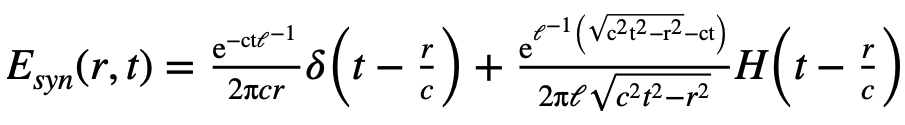

* l scattering mean free paths 
* c is the Rayleigh wave velocity
* r is the distance between the source and receiver
* H is the Heaviside function

* ### ***b is intrinsic absorption parameter***


In [2]:
# Dirac delta function
def impulse(x):
    return 1 * (x == 0)  

# Heaviside function (step function)
def step(x):
    return 1 * (x > 0)

# Esyn -->The 2-D radiative transfer equation for scalar waves 
def ESYN_RadiaTrans(mean_free,tm, r, c):
       
    s0=c**2 * tm**2 -r**2
    if s0 > 0:
        # first term
        a1up=math.exp(-1 * c * tm * (mean_free**(-1)))
        a1bot= 2 * math.pi * c * r
        #first= (a1up/a1bot)* scipy.signal.unit_impulse( tm-r/c ,'mid')
        first= (a1up/a1bot)* impulse( tm-r/c )
        
        # second term
        ind2=mean_free**(-1) * (math.sqrt(s0)-c*tm)
        a2up=math.exp(ind2)
        a2bot=2 * math.pi * mean_free * math.sqrt(s0)
        #second=(a2up)/(a2bot)* math.heaviside(tm-r/c)
        second=(a2up/a2bot)* step(tm-r/c)
        
        #print("A1: %.4f %.4f %.4f " % ((a1up/a1bot),a1up,a1bot),"  , A2: %.4f %.4f %.4f " % ((a2up/a2bot),a2up,a2bot))    
        Esyn= first + second
    
        return Esyn

In [3]:
def plot_fitting_curves(mean_free,intrinsic_b,tt,Esyn,dist):
    
    plt.figure(figsize=(6,3))

    plt.yscale('log', base=10) 
    #plt.ylim( np.max(Esyn[:-2]/1000) , np.max(Esyn[:-2]*2) )
    plt.plot( tt, Esyn, "b-", linewidth=1)  

    plt.title("mean_free: %.2f  b: %.2f @ %.2fkm"
            % ( mean_free,intrinsic_b,dist))
    plt.xlabel("Time [s]")
    plt.ylabel("Energy density Amplitude")
    plt.tight_layout()   
    plt.show()            

def plot_EsynOfR(mean_free,intrinsic_b,tt,Esyn_all,Rdist):
    
    plt.figure(figsize=(6,3))
    plt.yscale('log', base=10)
    for m in range(len(Rdist)):
        plt.plot( tt, Esyn_all[m], "b-", linewidth=1)  

    plt.title("mean_free: %.2f  b: %.2f @ %.2f ~ %.2fkm"
            % ( mean_free,intrinsic_b,Rdist[0],Rdist[-1]))
    plt.xlabel("Time [s]")
    plt.ylabel("Energy density Amplitude")
    plt.tight_layout()   
    plt.show()            
                     

## Test with Mean_free path

In [9]:
npts=1000
dt=0.05

Rdist=[*range(0,20,2)]
Esyn=np.ndarray((len(Rdist),npts))
tt=np.ndarray((npts))


SRdist:   0.00000001  , mean_free_path 0.20  , intrinsic_b 0.24 
SRdist:   2.00000001  , mean_free_path 0.20  , intrinsic_b 0.24 
SRdist:   4.00000001  , mean_free_path 0.20  , intrinsic_b 0.24 
SRdist:   6.00000001  , mean_free_path 0.20  , intrinsic_b 0.24 
SRdist:   8.00000001  , mean_free_path 0.20  , intrinsic_b 0.24 
SRdist:  10.00000001  , mean_free_path 0.20  , intrinsic_b 0.24 
SRdist:  12.00000001  , mean_free_path 0.20  , intrinsic_b 0.24 
SRdist:  14.00000001  , mean_free_path 0.20  , intrinsic_b 0.24 
SRdist:  16.00000001  , mean_free_path 0.20  , intrinsic_b 0.24 
SRdist:  18.00000001  , mean_free_path 0.20  , intrinsic_b 0.24 


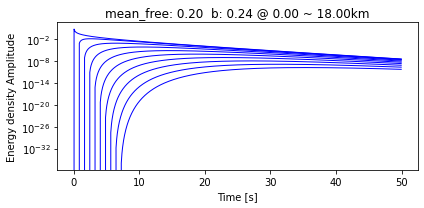

SRdist:   0.00000001  , mean_free_path 1.00  , intrinsic_b 0.24 
SRdist:   2.00000001  , mean_free_path 1.00  , intrinsic_b 0.24 
SRdist:   4.00000001  , mean_free_path 1.00  , intrinsic_b 0.24 
SRdist:   6.00000001  , mean_free_path 1.00  , intrinsic_b 0.24 
SRdist:   8.00000001  , mean_free_path 1.00  , intrinsic_b 0.24 
SRdist:  10.00000001  , mean_free_path 1.00  , intrinsic_b 0.24 
SRdist:  12.00000001  , mean_free_path 1.00  , intrinsic_b 0.24 
SRdist:  14.00000001  , mean_free_path 1.00  , intrinsic_b 0.24 
SRdist:  16.00000001  , mean_free_path 1.00  , intrinsic_b 0.24 
SRdist:  18.00000001  , mean_free_path 1.00  , intrinsic_b 0.24 


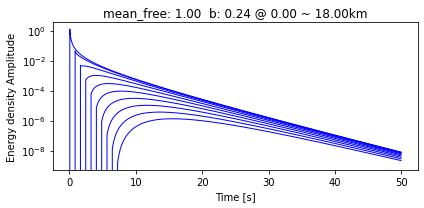

SRdist:   0.00000001  , mean_free_path 1.80  , intrinsic_b 0.24 
SRdist:   2.00000001  , mean_free_path 1.80  , intrinsic_b 0.24 
SRdist:   4.00000001  , mean_free_path 1.80  , intrinsic_b 0.24 
SRdist:   6.00000001  , mean_free_path 1.80  , intrinsic_b 0.24 
SRdist:   8.00000001  , mean_free_path 1.80  , intrinsic_b 0.24 
SRdist:  10.00000001  , mean_free_path 1.80  , intrinsic_b 0.24 
SRdist:  12.00000001  , mean_free_path 1.80  , intrinsic_b 0.24 
SRdist:  14.00000001  , mean_free_path 1.80  , intrinsic_b 0.24 
SRdist:  16.00000001  , mean_free_path 1.80  , intrinsic_b 0.24 
SRdist:  18.00000001  , mean_free_path 1.80  , intrinsic_b 0.24 


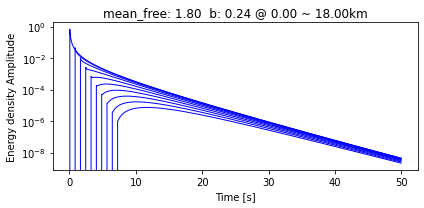

SRdist:   0.00000001  , mean_free_path 2.60  , intrinsic_b 0.24 
SRdist:   2.00000001  , mean_free_path 2.60  , intrinsic_b 0.24 
SRdist:   4.00000001  , mean_free_path 2.60  , intrinsic_b 0.24 
SRdist:   6.00000001  , mean_free_path 2.60  , intrinsic_b 0.24 
SRdist:   8.00000001  , mean_free_path 2.60  , intrinsic_b 0.24 
SRdist:  10.00000001  , mean_free_path 2.60  , intrinsic_b 0.24 
SRdist:  12.00000001  , mean_free_path 2.60  , intrinsic_b 0.24 
SRdist:  14.00000001  , mean_free_path 2.60  , intrinsic_b 0.24 
SRdist:  16.00000001  , mean_free_path 2.60  , intrinsic_b 0.24 
SRdist:  18.00000001  , mean_free_path 2.60  , intrinsic_b 0.24 


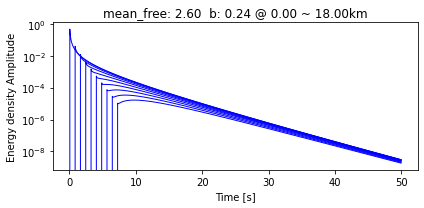

SRdist:   0.00000001  , mean_free_path 3.40  , intrinsic_b 0.24 
SRdist:   2.00000001  , mean_free_path 3.40  , intrinsic_b 0.24 
SRdist:   4.00000001  , mean_free_path 3.40  , intrinsic_b 0.24 
SRdist:   6.00000001  , mean_free_path 3.40  , intrinsic_b 0.24 
SRdist:   8.00000001  , mean_free_path 3.40  , intrinsic_b 0.24 
SRdist:  10.00000001  , mean_free_path 3.40  , intrinsic_b 0.24 
SRdist:  12.00000001  , mean_free_path 3.40  , intrinsic_b 0.24 
SRdist:  14.00000001  , mean_free_path 3.40  , intrinsic_b 0.24 
SRdist:  16.00000001  , mean_free_path 3.40  , intrinsic_b 0.24 
SRdist:  18.00000001  , mean_free_path 3.40  , intrinsic_b 0.24 


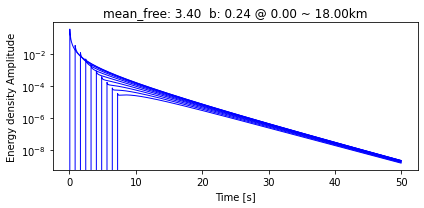

SRdist:   0.00000001  , mean_free_path 4.20  , intrinsic_b 0.24 
SRdist:   2.00000001  , mean_free_path 4.20  , intrinsic_b 0.24 
SRdist:   4.00000001  , mean_free_path 4.20  , intrinsic_b 0.24 
SRdist:   6.00000001  , mean_free_path 4.20  , intrinsic_b 0.24 
SRdist:   8.00000001  , mean_free_path 4.20  , intrinsic_b 0.24 
SRdist:  10.00000001  , mean_free_path 4.20  , intrinsic_b 0.24 
SRdist:  12.00000001  , mean_free_path 4.20  , intrinsic_b 0.24 
SRdist:  14.00000001  , mean_free_path 4.20  , intrinsic_b 0.24 
SRdist:  16.00000001  , mean_free_path 4.20  , intrinsic_b 0.24 
SRdist:  18.00000001  , mean_free_path 4.20  , intrinsic_b 0.24 


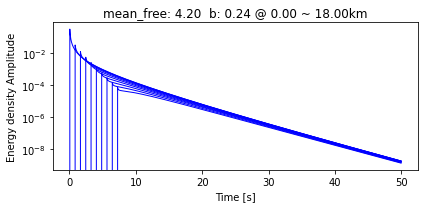

SRdist:   0.00000001  , mean_free_path 5.00  , intrinsic_b 0.24 
SRdist:   2.00000001  , mean_free_path 5.00  , intrinsic_b 0.24 
SRdist:   4.00000001  , mean_free_path 5.00  , intrinsic_b 0.24 
SRdist:   6.00000001  , mean_free_path 5.00  , intrinsic_b 0.24 
SRdist:   8.00000001  , mean_free_path 5.00  , intrinsic_b 0.24 
SRdist:  10.00000001  , mean_free_path 5.00  , intrinsic_b 0.24 
SRdist:  12.00000001  , mean_free_path 5.00  , intrinsic_b 0.24 
SRdist:  14.00000001  , mean_free_path 5.00  , intrinsic_b 0.24 
SRdist:  16.00000001  , mean_free_path 5.00  , intrinsic_b 0.24 
SRdist:  18.00000001  , mean_free_path 5.00  , intrinsic_b 0.24 


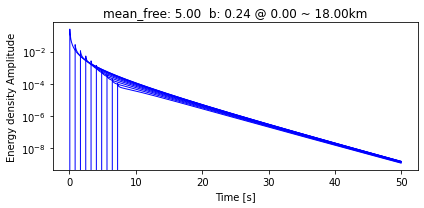

SRdist:   0.00000001  , mean_free_path 5.80  , intrinsic_b 0.24 
SRdist:   2.00000001  , mean_free_path 5.80  , intrinsic_b 0.24 
SRdist:   4.00000001  , mean_free_path 5.80  , intrinsic_b 0.24 
SRdist:   6.00000001  , mean_free_path 5.80  , intrinsic_b 0.24 
SRdist:   8.00000001  , mean_free_path 5.80  , intrinsic_b 0.24 
SRdist:  10.00000001  , mean_free_path 5.80  , intrinsic_b 0.24 
SRdist:  12.00000001  , mean_free_path 5.80  , intrinsic_b 0.24 
SRdist:  14.00000001  , mean_free_path 5.80  , intrinsic_b 0.24 
SRdist:  16.00000001  , mean_free_path 5.80  , intrinsic_b 0.24 
SRdist:  18.00000001  , mean_free_path 5.80  , intrinsic_b 0.24 


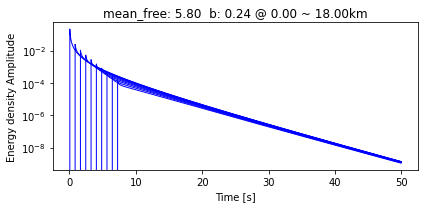

SRdist:   0.00000001  , mean_free_path 6.60  , intrinsic_b 0.24 
SRdist:   2.00000001  , mean_free_path 6.60  , intrinsic_b 0.24 
SRdist:   4.00000001  , mean_free_path 6.60  , intrinsic_b 0.24 
SRdist:   6.00000001  , mean_free_path 6.60  , intrinsic_b 0.24 
SRdist:   8.00000001  , mean_free_path 6.60  , intrinsic_b 0.24 
SRdist:  10.00000001  , mean_free_path 6.60  , intrinsic_b 0.24 
SRdist:  12.00000001  , mean_free_path 6.60  , intrinsic_b 0.24 
SRdist:  14.00000001  , mean_free_path 6.60  , intrinsic_b 0.24 
SRdist:  16.00000001  , mean_free_path 6.60  , intrinsic_b 0.24 
SRdist:  18.00000001  , mean_free_path 6.60  , intrinsic_b 0.24 


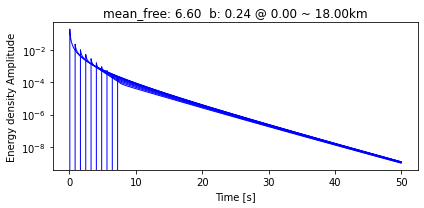

SRdist:   0.00000001  , mean_free_path 7.40  , intrinsic_b 0.24 
SRdist:   2.00000001  , mean_free_path 7.40  , intrinsic_b 0.24 
SRdist:   4.00000001  , mean_free_path 7.40  , intrinsic_b 0.24 
SRdist:   6.00000001  , mean_free_path 7.40  , intrinsic_b 0.24 
SRdist:   8.00000001  , mean_free_path 7.40  , intrinsic_b 0.24 
SRdist:  10.00000001  , mean_free_path 7.40  , intrinsic_b 0.24 
SRdist:  12.00000001  , mean_free_path 7.40  , intrinsic_b 0.24 
SRdist:  14.00000001  , mean_free_path 7.40  , intrinsic_b 0.24 
SRdist:  16.00000001  , mean_free_path 7.40  , intrinsic_b 0.24 
SRdist:  18.00000001  , mean_free_path 7.40  , intrinsic_b 0.24 


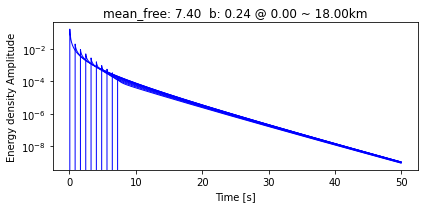

SRdist:   0.00000001  , mean_free_path 8.20  , intrinsic_b 0.24 
SRdist:   2.00000001  , mean_free_path 8.20  , intrinsic_b 0.24 
SRdist:   4.00000001  , mean_free_path 8.20  , intrinsic_b 0.24 
SRdist:   6.00000001  , mean_free_path 8.20  , intrinsic_b 0.24 
SRdist:   8.00000001  , mean_free_path 8.20  , intrinsic_b 0.24 
SRdist:  10.00000001  , mean_free_path 8.20  , intrinsic_b 0.24 
SRdist:  12.00000001  , mean_free_path 8.20  , intrinsic_b 0.24 
SRdist:  14.00000001  , mean_free_path 8.20  , intrinsic_b 0.24 
SRdist:  16.00000001  , mean_free_path 8.20  , intrinsic_b 0.24 
SRdist:  18.00000001  , mean_free_path 8.20  , intrinsic_b 0.24 


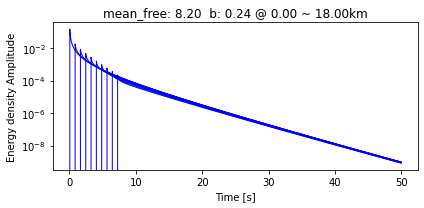

SRdist:   0.00000001  , mean_free_path 9.00  , intrinsic_b 0.24 
SRdist:   2.00000001  , mean_free_path 9.00  , intrinsic_b 0.24 
SRdist:   4.00000001  , mean_free_path 9.00  , intrinsic_b 0.24 
SRdist:   6.00000001  , mean_free_path 9.00  , intrinsic_b 0.24 
SRdist:   8.00000001  , mean_free_path 9.00  , intrinsic_b 0.24 
SRdist:  10.00000001  , mean_free_path 9.00  , intrinsic_b 0.24 
SRdist:  12.00000001  , mean_free_path 9.00  , intrinsic_b 0.24 
SRdist:  14.00000001  , mean_free_path 9.00  , intrinsic_b 0.24 
SRdist:  16.00000001  , mean_free_path 9.00  , intrinsic_b 0.24 
SRdist:  18.00000001  , mean_free_path 9.00  , intrinsic_b 0.24 


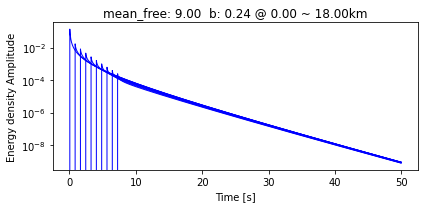

SRdist:   0.00000001  , mean_free_path 9.80  , intrinsic_b 0.24 
SRdist:   2.00000001  , mean_free_path 9.80  , intrinsic_b 0.24 
SRdist:   4.00000001  , mean_free_path 9.80  , intrinsic_b 0.24 
SRdist:   6.00000001  , mean_free_path 9.80  , intrinsic_b 0.24 
SRdist:   8.00000001  , mean_free_path 9.80  , intrinsic_b 0.24 
SRdist:  10.00000001  , mean_free_path 9.80  , intrinsic_b 0.24 
SRdist:  12.00000001  , mean_free_path 9.80  , intrinsic_b 0.24 
SRdist:  14.00000001  , mean_free_path 9.80  , intrinsic_b 0.24 
SRdist:  16.00000001  , mean_free_path 9.80  , intrinsic_b 0.24 
SRdist:  18.00000001  , mean_free_path 9.80  , intrinsic_b 0.24 


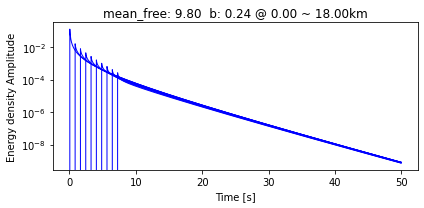

In [11]:

c=2.5
intrinsic_b=0.24

# Mean_free_path
mfpath=np.arange(0.2,10,0.8)

for nfree in range(len(mfpath)):
    mean_free=mfpath[nfree]
    Rdist=[*range(0,20,2)]
    for m in range(len(Rdist)):
        Rdist[m]=Rdist[m]+0.00000001
        print("SRdist: %12.8f " % Rdist[m],", mean_free_path %.2f " % mean_free,", intrinsic_b %.2f " % intrinsic_b)
        r=Rdist[m]
        Esyn[m]=0.
        # calculate the Esyn and SSR for combination of mean_free_path and intrinsic_b
        for twn in range(npts):
            tm=dt*twn
            tt[twn]=tm
            s0=c**2 * tm**2 -r**2
            if s0 <= 0:
                #print(twn,tm,s0,tm-r/c)
                continue

            tmp=ESYN_RadiaTrans(mean_free, tm , r, c)
            Esyn[m][twn]= tmp  * math.exp(-1* intrinsic_b * tm)  

        #print(np.min(Esyn_temp[:]),np.max(Esyn_temp[:]))
        #plot_fitting_curves(mean_free,intrinsic_b,tt,Esyn[m],r)

    plot_EsynOfR(mean_free,intrinsic_b,tt,Esyn,Rdist)

## Test with intrinsic absoption parameter b

SRdist:   0.00000001  , mean_free_path 2.00  , intrinsic_b 0.02 
SRdist:   2.00000001  , mean_free_path 2.00  , intrinsic_b 0.02 
SRdist:   4.00000001  , mean_free_path 2.00  , intrinsic_b 0.02 
SRdist:   6.00000001  , mean_free_path 2.00  , intrinsic_b 0.02 
SRdist:   8.00000001  , mean_free_path 2.00  , intrinsic_b 0.02 
SRdist:  10.00000001  , mean_free_path 2.00  , intrinsic_b 0.02 
SRdist:  12.00000001  , mean_free_path 2.00  , intrinsic_b 0.02 
SRdist:  14.00000001  , mean_free_path 2.00  , intrinsic_b 0.02 
SRdist:  16.00000001  , mean_free_path 2.00  , intrinsic_b 0.02 
SRdist:  18.00000001  , mean_free_path 2.00  , intrinsic_b 0.02 


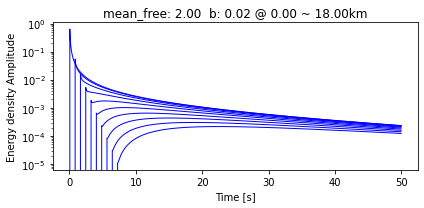

SRdist:   0.00000001  , mean_free_path 2.00  , intrinsic_b 0.06 
SRdist:   2.00000001  , mean_free_path 2.00  , intrinsic_b 0.06 
SRdist:   4.00000001  , mean_free_path 2.00  , intrinsic_b 0.06 
SRdist:   6.00000001  , mean_free_path 2.00  , intrinsic_b 0.06 
SRdist:   8.00000001  , mean_free_path 2.00  , intrinsic_b 0.06 
SRdist:  10.00000001  , mean_free_path 2.00  , intrinsic_b 0.06 
SRdist:  12.00000001  , mean_free_path 2.00  , intrinsic_b 0.06 
SRdist:  14.00000001  , mean_free_path 2.00  , intrinsic_b 0.06 
SRdist:  16.00000001  , mean_free_path 2.00  , intrinsic_b 0.06 
SRdist:  18.00000001  , mean_free_path 2.00  , intrinsic_b 0.06 


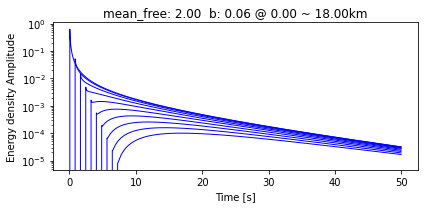

SRdist:   0.00000001  , mean_free_path 2.00  , intrinsic_b 0.10 
SRdist:   2.00000001  , mean_free_path 2.00  , intrinsic_b 0.10 
SRdist:   4.00000001  , mean_free_path 2.00  , intrinsic_b 0.10 
SRdist:   6.00000001  , mean_free_path 2.00  , intrinsic_b 0.10 
SRdist:   8.00000001  , mean_free_path 2.00  , intrinsic_b 0.10 
SRdist:  10.00000001  , mean_free_path 2.00  , intrinsic_b 0.10 
SRdist:  12.00000001  , mean_free_path 2.00  , intrinsic_b 0.10 
SRdist:  14.00000001  , mean_free_path 2.00  , intrinsic_b 0.10 
SRdist:  16.00000001  , mean_free_path 2.00  , intrinsic_b 0.10 
SRdist:  18.00000001  , mean_free_path 2.00  , intrinsic_b 0.10 


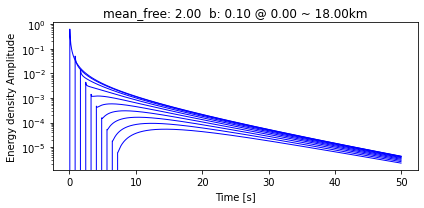

SRdist:   0.00000001  , mean_free_path 2.00  , intrinsic_b 0.14 
SRdist:   2.00000001  , mean_free_path 2.00  , intrinsic_b 0.14 
SRdist:   4.00000001  , mean_free_path 2.00  , intrinsic_b 0.14 
SRdist:   6.00000001  , mean_free_path 2.00  , intrinsic_b 0.14 
SRdist:   8.00000001  , mean_free_path 2.00  , intrinsic_b 0.14 
SRdist:  10.00000001  , mean_free_path 2.00  , intrinsic_b 0.14 
SRdist:  12.00000001  , mean_free_path 2.00  , intrinsic_b 0.14 
SRdist:  14.00000001  , mean_free_path 2.00  , intrinsic_b 0.14 
SRdist:  16.00000001  , mean_free_path 2.00  , intrinsic_b 0.14 
SRdist:  18.00000001  , mean_free_path 2.00  , intrinsic_b 0.14 


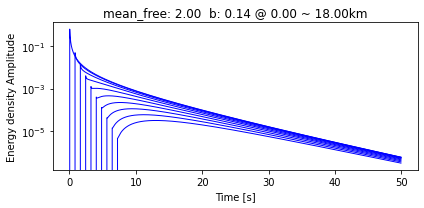

SRdist:   0.00000001  , mean_free_path 2.00  , intrinsic_b 0.18 
SRdist:   2.00000001  , mean_free_path 2.00  , intrinsic_b 0.18 
SRdist:   4.00000001  , mean_free_path 2.00  , intrinsic_b 0.18 
SRdist:   6.00000001  , mean_free_path 2.00  , intrinsic_b 0.18 
SRdist:   8.00000001  , mean_free_path 2.00  , intrinsic_b 0.18 
SRdist:  10.00000001  , mean_free_path 2.00  , intrinsic_b 0.18 
SRdist:  12.00000001  , mean_free_path 2.00  , intrinsic_b 0.18 
SRdist:  14.00000001  , mean_free_path 2.00  , intrinsic_b 0.18 
SRdist:  16.00000001  , mean_free_path 2.00  , intrinsic_b 0.18 
SRdist:  18.00000001  , mean_free_path 2.00  , intrinsic_b 0.18 


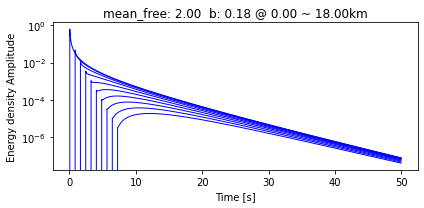

SRdist:   0.00000001  , mean_free_path 2.00  , intrinsic_b 0.22 
SRdist:   2.00000001  , mean_free_path 2.00  , intrinsic_b 0.22 
SRdist:   4.00000001  , mean_free_path 2.00  , intrinsic_b 0.22 
SRdist:   6.00000001  , mean_free_path 2.00  , intrinsic_b 0.22 
SRdist:   8.00000001  , mean_free_path 2.00  , intrinsic_b 0.22 
SRdist:  10.00000001  , mean_free_path 2.00  , intrinsic_b 0.22 
SRdist:  12.00000001  , mean_free_path 2.00  , intrinsic_b 0.22 
SRdist:  14.00000001  , mean_free_path 2.00  , intrinsic_b 0.22 
SRdist:  16.00000001  , mean_free_path 2.00  , intrinsic_b 0.22 
SRdist:  18.00000001  , mean_free_path 2.00  , intrinsic_b 0.22 


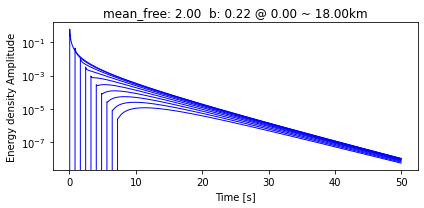

SRdist:   0.00000001  , mean_free_path 2.00  , intrinsic_b 0.26 
SRdist:   2.00000001  , mean_free_path 2.00  , intrinsic_b 0.26 
SRdist:   4.00000001  , mean_free_path 2.00  , intrinsic_b 0.26 
SRdist:   6.00000001  , mean_free_path 2.00  , intrinsic_b 0.26 
SRdist:   8.00000001  , mean_free_path 2.00  , intrinsic_b 0.26 
SRdist:  10.00000001  , mean_free_path 2.00  , intrinsic_b 0.26 
SRdist:  12.00000001  , mean_free_path 2.00  , intrinsic_b 0.26 
SRdist:  14.00000001  , mean_free_path 2.00  , intrinsic_b 0.26 
SRdist:  16.00000001  , mean_free_path 2.00  , intrinsic_b 0.26 
SRdist:  18.00000001  , mean_free_path 2.00  , intrinsic_b 0.26 


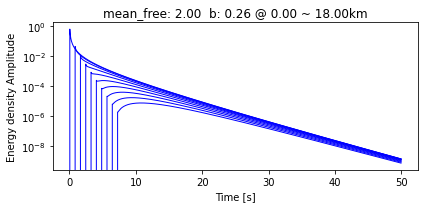

SRdist:   0.00000001  , mean_free_path 2.00  , intrinsic_b 0.30 
SRdist:   2.00000001  , mean_free_path 2.00  , intrinsic_b 0.30 
SRdist:   4.00000001  , mean_free_path 2.00  , intrinsic_b 0.30 
SRdist:   6.00000001  , mean_free_path 2.00  , intrinsic_b 0.30 
SRdist:   8.00000001  , mean_free_path 2.00  , intrinsic_b 0.30 
SRdist:  10.00000001  , mean_free_path 2.00  , intrinsic_b 0.30 
SRdist:  12.00000001  , mean_free_path 2.00  , intrinsic_b 0.30 
SRdist:  14.00000001  , mean_free_path 2.00  , intrinsic_b 0.30 
SRdist:  16.00000001  , mean_free_path 2.00  , intrinsic_b 0.30 
SRdist:  18.00000001  , mean_free_path 2.00  , intrinsic_b 0.30 


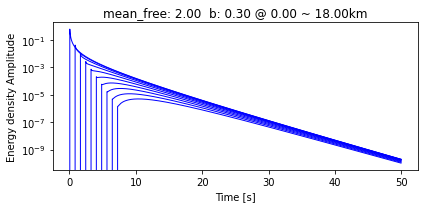

SRdist:   0.00000001  , mean_free_path 2.00  , intrinsic_b 0.34 
SRdist:   2.00000001  , mean_free_path 2.00  , intrinsic_b 0.34 
SRdist:   4.00000001  , mean_free_path 2.00  , intrinsic_b 0.34 
SRdist:   6.00000001  , mean_free_path 2.00  , intrinsic_b 0.34 
SRdist:   8.00000001  , mean_free_path 2.00  , intrinsic_b 0.34 
SRdist:  10.00000001  , mean_free_path 2.00  , intrinsic_b 0.34 
SRdist:  12.00000001  , mean_free_path 2.00  , intrinsic_b 0.34 
SRdist:  14.00000001  , mean_free_path 2.00  , intrinsic_b 0.34 
SRdist:  16.00000001  , mean_free_path 2.00  , intrinsic_b 0.34 
SRdist:  18.00000001  , mean_free_path 2.00  , intrinsic_b 0.34 


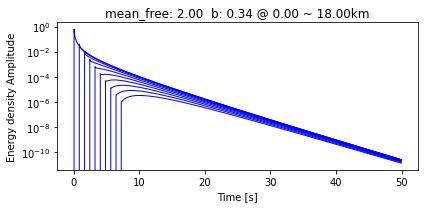

SRdist:   0.00000001  , mean_free_path 2.00  , intrinsic_b 0.38 
SRdist:   2.00000001  , mean_free_path 2.00  , intrinsic_b 0.38 
SRdist:   4.00000001  , mean_free_path 2.00  , intrinsic_b 0.38 
SRdist:   6.00000001  , mean_free_path 2.00  , intrinsic_b 0.38 
SRdist:   8.00000001  , mean_free_path 2.00  , intrinsic_b 0.38 
SRdist:  10.00000001  , mean_free_path 2.00  , intrinsic_b 0.38 
SRdist:  12.00000001  , mean_free_path 2.00  , intrinsic_b 0.38 
SRdist:  14.00000001  , mean_free_path 2.00  , intrinsic_b 0.38 
SRdist:  16.00000001  , mean_free_path 2.00  , intrinsic_b 0.38 
SRdist:  18.00000001  , mean_free_path 2.00  , intrinsic_b 0.38 


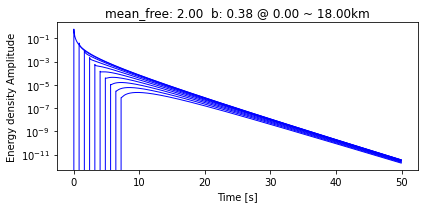

In [12]:

c=2.5
mean_free=2

intb=np.arange(0.02,0.4,0.04)

for nb in range(len(intb)):
    intrinsic_b=intb[nb]
    for m in range(len(Rdist)):
        print("SRdist: %12.8f " % Rdist[m],", mean_free_path %.2f " % mean_free,", intrinsic_b %.2f " % intrinsic_b)
        r=Rdist[m]
        Esyn[m]=0.
        # calculate the Esyn and SSR for combination of mean_free_path and intrinsic_b
        for twn in range(npts):
            tm=dt*twn
            tt[twn]=tm
            s0=c**2 * tm**2 -r**2
            if s0 <= 0:
                #print(twn,tm,s0,tm-r/c)
                continue

            tmp=ESYN_RadiaTrans(mean_free, tm , r, c)
            Esyn[m][twn]= tmp  * math.exp(-1* intrinsic_b * tm)  

        #print(np.min(Esyn_temp[:]),np.max(Esyn_temp[:]))
        #plot_fitting_curves(mean_free,intrinsic_b,tt,Esyn[m],r)

    plot_EsynOfR(mean_free,intrinsic_b,tt,Esyn,Rdist)